# CITIES INFORMATIONS
This notebook is used to show how Graph RAG performs when structured and unstructured data are both used in the logic.
It will be showed :
  - how to ingest different kind of data (online PDF files, tabular CSV data, ecc...)
  - how to instantiate the LLM and Langchain
  - how to connect to a Neo4j instance in order to show the generated graph
  - how to query the Neo4j graph
  - how to use the prompts to query the LLM

## STEP 0 - Imports

In [1]:
import os
import re
import dotenv
import requests
import deepmatcher as dm
import pandas as pd

from datasets import Dataset, Features, Value
from langchain.retrievers.document_compressors import EmbeddingsFilter
from tqdm import tqdm

from langchain.text_splitter import CharacterTextSplitter
from langchain.chains import GraphCypherQAChain
from langchain.chains.llm import LLMChain
from langchain.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_groq import ChatGroq
from langchain_community.document_loaders import CSVLoader
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.graphs import Neo4jGraph
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from sklearn.model_selection import train_test_split

from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    answer_correctness,
    answer_similarity
)
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas import EvaluationDataset

In [2]:
dotenv.load_dotenv()

NEO4J_URI = os.environ["NEO4J_URI"]
NEO4J_USERNAME = os.environ["NEO4J_USERNAME"]
NEO4J_PASSWORD = os.environ["NEO4J_PASSWORD"]
NEO4J_RAG_USERNAME = os.environ["NEO4J_RAG_USERNAME"]
NEO4J_RAG_PASSWORD = os.environ["NEO4J_RAG_PASSWORD"]
GROQ_API_KEY = os.environ["GROQ_API_KEY"]
OPEN_AQ_API_KEY = os.environ["OPEN_AQ_API_KEY"]









<br><br><br><br><br><br><br>
## STEP 1 - Documents and table ingestion
In this phase, it is necessary to provide the dataset used to feed the Knowledge graph. To do this, we will ingest some PDF files containing informations about cities' air pollution and a table with all the data of most of the cities in the world.

### Step 1.1 - Documents ingestion

In [3]:
urls = [
    "https://www.istat.it/en/files/2011/01/qualita_aria_EN.pdf?title=Air+quality+in+European+cities+-+22+Jun+2010+-+qualita_aria_EN.pdf",
]

csvFilePath = ".\\dataset\\worldcities.csv"

In [4]:
headers = {"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/128.0.0.0 Safari/537.36"}
docs = [PyPDFLoader(url, headers=headers).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

### Step 1.2 - Documents' text splitting

In [5]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(chunk_size=7500, chunk_overlap=100)
doc_splits = text_splitter.split_documents(docs_list)

### Step 1.3 - OpenAQ API invocation
This phase is required to retrieve Air Quality infos for enriching the graph with more data.
Infos usage will be posticipated to the **"STEP 3 - Neo4j and graph insertion"** since it is necessary to upload the **worldcities.csv** file directly into the graph DB

In [6]:
base_url = 'https://api.openaq.org/v1/latest'
headers = {
    'X-API-Key': OPEN_AQ_API_KEY
}
parameters = {
        'limit': 990,
        'country': "IT"
    }
locations_data = requests.get(base_url, headers=headers, params=parameters)
locations_json = locations_data.json()['results']

KeyError: 'results'









<br><br><br><br><br><br><br>
## STEP 2 - Large Language Model and Graph generation from Documents
This is one of the most important steps to cover: here we are going to instantiate the LLM (Large Language Model) used to extract the Entity and the Relationships from the documents in order to obtain the Nodes (entities) and Edges (relationships) of the Graph used in GraphRAG.

In [7]:
llm = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model_name="llama3-70b-8192",
    timeout=None)
llm_transformer=LLMGraphTransformer(llm=llm)

In [ ]:
graph_documents=llm_transformer.convert_to_graph_documents(doc_splits)
# graph_documents









<br><br><br><br><br><br><br>
## STEP 3 - Neo4j and graph insertion
Now it is time to save the originated graph into a persistent Neo4j instance.

### Step 3.1 - Initialize Neo4j connection

In [ ]:
database_name = "progettotesi"

graph=Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_USERNAME,
    password=NEO4J_PASSWORD,
    database=database_name
)

### Step 3.2 - Import nodes

#### Step 3.2.1 - Import nodes from CSV file
This step allows to import nodes that are stored inside the "worldcities.csv" file.
<br>
**NB**: CSV loading has been performed manually to save time
These are the steps to execute to do it manually:
1.  add the file "worldcities.csv" inside the Neo4j project's "import" folder
2.  go to the folder "bin" inside the Neo4j project's folder
3.  use the following command inside Neo4j terminal:

neo4j-admin database import full progettotesi --delimiter=";" --array-delimiter="U+007C" --nodes=import/worldcities.csv

In [ ]:
# graph.query(
#     query = "LOAD CSV WITH HEADERS "
#     "FROM 'file:///C:/Universit%C3%A0/Tesi/Matching-Graph-Rag/EMG%20RAG/worldcities.csv' as row "
#     "MERGE("
#         "m:City{"
#             "id: row.city_ascii, "
#             "latitude: row.lat, "
#             "longitude: row.lng, "
#             "country: row.country, "
#             "iso2: row.iso2, "
#             "iso3: row.iso3, "
#             "administrative_name: row.admin_name, "
#             "capital: row.capital, "
#             "population: row.population"
#         "}"
#     ")")

#### Step 3.2.2 - Import nodes from Graph Documents
Similarly to what has been done with CSV file, it is necessary to write Cypher queries to insert **nodes** and **relationships** got from the LLM in **Step 2**.
<br>
However, this time it is required to pre-process data in order to remove special characters, to uniform the new nodes to the already inserted ones and. eventually, to merge them if the same node already exist.
These are two of the most important phases of the **"Entity Matching"** (discussed below), in particular they are, in order, the **"Data Pre-Processing"** and the **"Schema Matching"** phases

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# Add etities (nodes) and relationships (edges) into the graph
nodes_as_dict = flatten([list({'id': node.id, 'type': node.type} for node in doc.nodes) for doc in graph_documents])

##########################
### DATA PREPROCESSING ###
##########################
edges_as_dict = flatten([list(
    {
        'type': rel.type,
        'source':{
            'id': rel.source.id,
            'type': rel.source.type
         },
        'target': {
            'id': rel.target.id,
            'type': rel.target.type
        }
    } for rel in doc.relationships) for doc in graph_documents])

In [ ]:
for node in nodes_as_dict:
    ##########################
    ### DATA PREPROCESSING ###
    ##########################
    node_type = re.sub('[^A-Za-z0-9]+', '', node["type"])


    #######################
    ### SCHEMA MATCHING ###
    #######################
    query = f"""
    MERGE (n:{node_type} {"{city_ascii: $id}" if node['type'] == "City" else "{id: $id}"})
    SET n.type = $type, n.updated = True
    """
    graph.query(query=query, params={"id": node["id"], "type": node["type"]})

In [ ]:
for relationship in edges_as_dict:
    ##########################
    ### DATA PREPROCESSING ###
    ##########################
    source_id = relationship["source"]["id"]
    source_type = re.sub('[^A-Za-z0-9]+', '', relationship["source"]["type"])

    target_id = relationship["target"]["id"]
    target_type = re.sub('[^A-Za-z0-9]+', '', relationship["target"]["type"])

    rel_type = re.sub('[^A-Za-z0-9]+', '', relationship["type"])


    #######################
    ### SCHEMA MATCHING ###
    #######################
    condition = "(a.type = \"City\" and a.country IS NOT NULL and b.type = \"Country\" and a.country <> id(b)) or (a.type = \"Country\" and b.type = \"City\" and b.country IS NOT NULL and id(a) <> b.country)"
    query = f"""
        MATCH (a:{source_type} {"{city_ascii: $source_id}" if source_type == "City" else "{id: $source_id}"})
        MATCH (b:{target_type} {"{city_ascii: $target_id}" if target_type == "City" else "{id: $target_id}"})
        CALL apoc.do.when(
            {condition},
            'RETURN null',
            'MERGE (a)-[r:{rel_type}]->(b) return a, r, b',
            {{a: a, b: b}}
        )
        YIELD value
        return value
    """


    graph.query(
        query=query,
        params={
            "source_id": source_id,
            "target_id": target_id
        }
    )

<br><br>
### 3.2.3 - Import nodes from location data
The same actions have to be performed for what concerns **location data**; in particular, it is necessary to pre-process data (in this case, the attribute "city" is referencing streets, municipalities and only the abbreviations of the province; at the same way, the "country" is represented by its code, like IT, EN, ES, ..., and not by its full name). To simplify the process, we are going to:
- map provinces abbreviations to city names using the **italian_provinces.csv** mapping file;
- map the country codes to their relative names using the **country_codes.csv**
- store them in Neo4j.

(i) **NB**: in this scenario, **only italian provinces are used**, so the **country_codes.csv** file is not used; it could be used in the future to extend the knowledge of the model.

In [ ]:
def insert_location_data(location_data):
    query_location = """
    MERGE (l:Location {name: $loc_name, city: $city, country: $country})
    SET l.latitude = $latitude, l.longitude = $longitude
    """

    graph.query(
        query_location,
        params={
            'loc_name': location_data['location'],
            'city': location_data['city'],
            'country': location_data['country'],
            'latitude': location_data['coordinates']['latitude'],
            'longitude': location_data['coordinates']['longitude']
        }
    )

    query_measurement = """
    MERGE (m:Measurement {parameter: $parameter, lastUpdated: $lastUpdated})
    SET m.value = $value, m.unit = $unit, m.sourceName = $sourceName, m.averagingPeriod = $averagingPeriod
    WITH m
    MATCH (l:Location {name: $loc_name})
    MERGE (l)-[:HAS_MEASUREMENT]->(m)
    """

    for measurement in location_data['measurements']:
        graph.query(
            query_measurement,
            params={
                'parameter': measurement['parameter'],
                'lastUpdated': measurement['lastUpdated'],
                'value': measurement['value'],
                'unit': measurement['unit'],
                'sourceName': measurement['sourceName'],
                'averagingPeriod': measurement['averagingPeriod']['value'],
                'loc_name': location_data['location']
            }
        )

    query_city_location_rel = """
    MATCH (l:Location), (c:City)
    WHERE l.city = c.city_ascii and l.country = c.country
    MERGE (l)-[:IS_LOCATION_OF]->(c)
    """

    graph.query(query_city_location_rel)


In [ ]:
italian_provinces = pd.read_csv(".\\mappings\\italian_provinces.csv")
country_codes =  pd.read_csv(".\\mappings\\country_codes.csv", sep=";")
for location_data in locations_json:
    if location_data['city'] is not None:
        matching_row = italian_provinces[italian_provinces['province_code'].apply(lambda code: str(code) in location_data['city'])]
        if not matching_row.empty:
            location_data['city'] = matching_row.iloc[0]['province_name']
    else:
        location_data['city'] = "No City"
    if location_data['country'] is not None:
        matching_row = country_codes[country_codes['country_code'].apply(lambda code: str(code) in location_data['country'])]
        if not matching_row.empty:
            location_data['country'] = matching_row.iloc[0]['country_name']
    else:
        location_data['city'] = "No Country"

In [ ]:
for location_data in locations_json:
    insert_location_data(location_data)









<br><br><br><br><br><br><br>
## STEP 4 - Entity matching
Since we're merging data from different data sources, some weird scenarios can occur:
-  nodes (and relationships) sometimes can be duplicated;
-  nodes (and relationships) sometimes can have different names to point to the same entity;
-  nodes (and relationships) that look pretty similar one to each other are representing very different entities;

To avoid these scenarios, it is necessary to "merge back the entities": this is the scope of the "Entity matching" phase!

For this goal, we'll use **Deepmatcher**, a deep learning-based Entity Matching system that leverages pre-trained language models to improve accuracy in identifying and matching similar entities across different datasets.

### Step 4.1 - Prepare dataframe for Deepmatcher
First of all, it is necessary to define a Golden Dataset to train Deepmatcher; in this project, the file neo4jCitiesGoldenDataset.csv will do the job. Once read, it'll be split in **train_set**, **val_set** and **test_set** in order to obtain the three **train**, **validation** and **test** datasets.

In [ ]:
# MATCH (c1:City)
# MATCH (c2:City)
# WHERE id(c1) < id(c2)
# WITH c1, c2,
#      apoc.text.levenshteinSimilarity(c1.city_ascii, c2.city_ascii) AS city_ascii_sim,
#      apoc.text.levenshteinSimilarity(c1.country, c2.country) AS country_sim
# RETURN
#     id(c1) AS ltable_id,
#     c1.city_ascii AS ltable_city_ascii,
#     c1.country AS ltable_country,
#     id(c2) AS rtable_id,
#     c2.city_ascii AS rtable_city_ascii,
#     c2.country AS rtable_country,
#     city_ascii_sim,
#     country_sim
# LIMIT 1000000

In [ ]:
goldenDataset = pd.read_csv(".\\dataset\\neo4jCitiesGoldenDataset.csv", sep=";", index_col="id")

### 4.2 - BLOCKING PHASE
this phase has the purpose of reducing the number of rows to be evaluated; in this particular scenario, two cities which have different country are automatically discarded since they can not be the same.

In [ ]:
blockedGoldenDataset = goldenDataset.loc[goldenDataset["ltable_country"] == goldenDataset["rtable_country"]][:10000]
len(blockedGoldenDataset)

In [ ]:
train_val_set, test_set = train_test_split(blockedGoldenDataset, test_size=0.2, random_state=42)
train_set, val_set = train_test_split(train_val_set, test_size=0.25, random_state=42)

In [ ]:
train_set.to_csv(".\\dataset\\train_set.csv", sep=",", index=True, index_label="id")
val_set.to_csv(".\\dataset\\val_set.csv", sep=",", index=True, index_label="id")
test_set.to_csv(".\\dataset\\test_set.csv", sep=",", index=True, index_label="id")

In [ ]:
train, validation, test = \
    dm.data.process(
        path='dataset',
        train="train_set.csv",
        validation="val_set.csv",
        test="test_set.csv",
        use_magellan_convention=False,
        label_attr='is_matching',
        left_prefix="ltable_",
        right_prefix="rtable_",
        ignore_columns=['city_ascii_sim', 'country_sim', 'ltable_id', 'rtable_id'],
        embeddings_cache_path=".vector_cache",
        embeddings='fasttext.en.bin'
    )

In [ ]:
val_table = validation.get_raw_table()
val_table.loc[val_table["is_matching"] == 1]

<br><br>
### Step 4.2 - Train the Matching model
Once the datasets are ready, it is possible to train the model with the **train** dataframe and then to fine-tuning it with **validation** dataframe.

In [ ]:
model = dm.MatchingModel(attr_summarizer='hybrid')
model.run_train(
    train,
    validation,
    epochs=12,
    batch_size=16,
    best_save_path='.\\dataset\\hybrid_model.pth',
    pos_neg_ratio=6,
    log_freq=5)

<br><br>
### Step 4.3 - Evaluate the model
Now the model is ready to be tested with a **test** dataframe; this step will show how the model performs with never-seen data.

In [ ]:
model.run_eval(test)

<br><br>
### Step 4.4 - Make predictions on real data
The model is ready for our final purpose: make the entities matching!
To do this, the model needs an **unlabeled dataset** (here we're referencing the **neo4jCitiesUnlabeled.csv** file): this particular dataset doesn't contain any attribute about if the entities are matching or not, so the model can not "cheat" and predictions will be genuine!

In [ ]:
unlabeled = dm.data.process_unlabeled(
    path='.\\dataset\\neo4jCitiesUnlabeled.csv',
    trained_model=model,
    ignore_columns=['city_ascii_sim', 'country_sim', 'ltable_id', 'rtable_id'])

In [ ]:
predictions = model.run_prediction(unlabeled, output_attributes=True)

In [ ]:
predictions.to_csv('predictions/unlabeled_predictions.csv')

### 4.5 - Prepare data from Neo4j
Once the predictions have been performed, it is possible to consult a new attribute inside the **"unlabeled_predictions.csv"** file: the "match_score". It refers to the match probability between a entities pair; so, for example, if two entities have a match_score above a certain threshold (**in this scenario, the threshold is set to 68%**), they will be considered matching!

Before merging nodes and relationships in Neo4j, the rows inside "predictions" variable are filtered to get only the ones which have a match_score above 68%. Then, the Cypher function **apoc.refactor.mergeNodes** will be used to merge nodes (and their relationships) inside Neo4j.

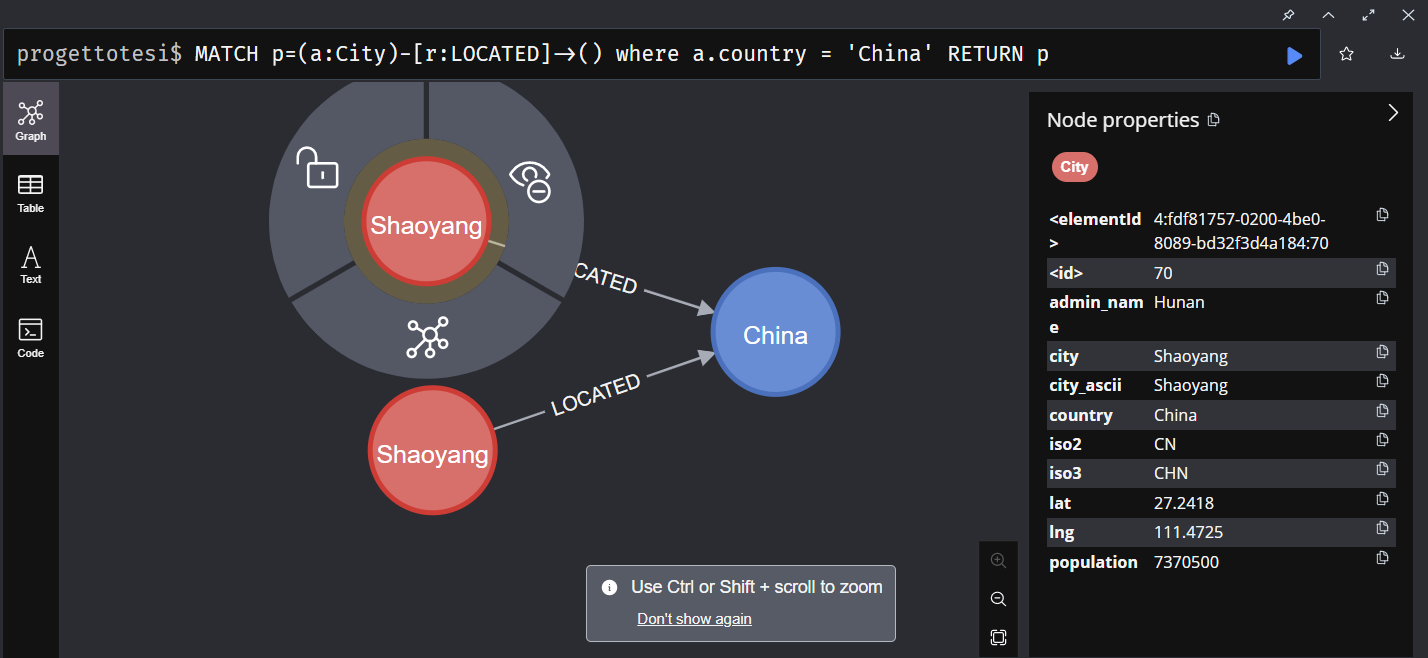

In [ ]:
matching_treshold = 0.68
if 'predictions' not in globals():
    predictions = pd.read_csv(".\\predictions\\unlabeled_predictions.csv")

matches_to_merge = predictions[predictions['match_score'] > matching_treshold]
for _, row in matches_to_merge.iterrows():
        query = f"""
        MATCH (left:City), (right:City)
        WHERE ID(left) = {row['ltable_id']} and ID(right) = {row['rtable_id']}
        CALL apoc.refactor.mergeNodes([left, right], {{properties: 'combine', mergeRels: true}}) YIELD node
        SET node.match_score = {row['match_score']}
        RETURN node
        """
        # Esegui la query sul grafo
        graph.query(query=query)

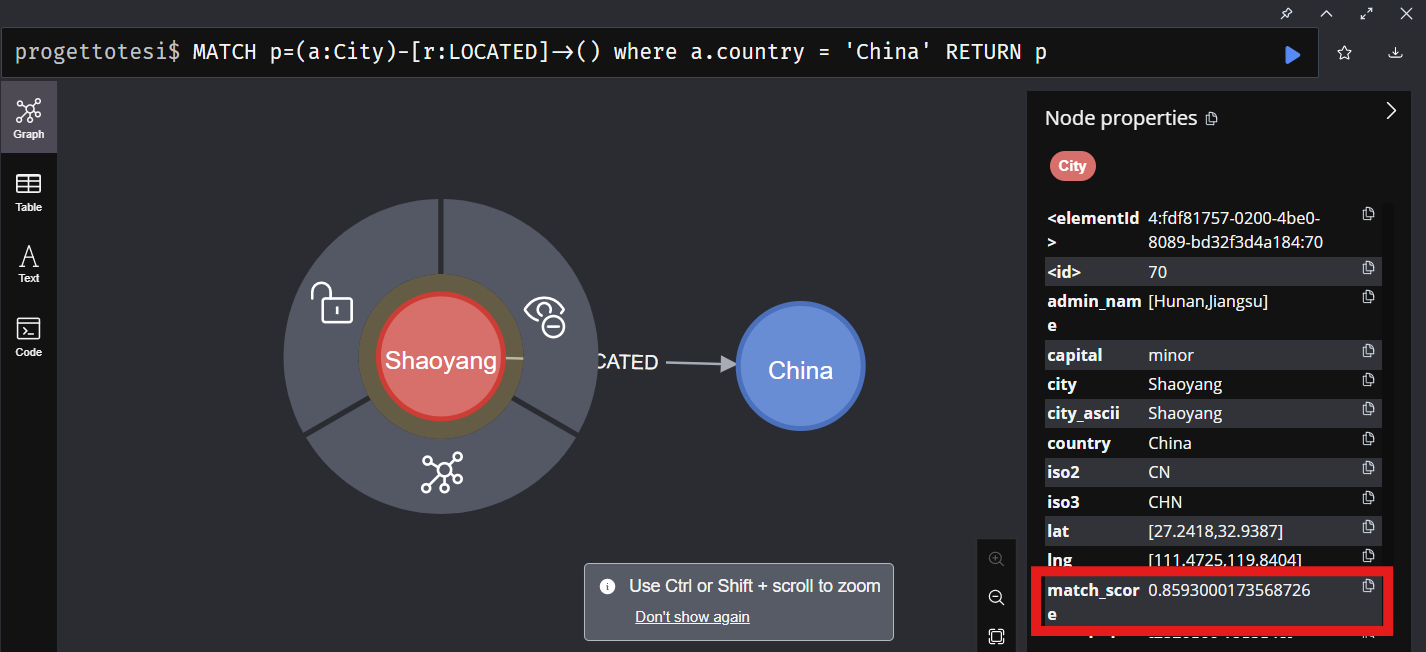









<br><br><br><br><br><br><br>
## STEP 5 - Entity Matching Graph RAG in action

In [7]:
graph_RAG=Neo4jGraph(
    url=NEO4J_URI,
    username=NEO4J_RAG_USERNAME,
    password=NEO4J_RAG_PASSWORD,
    database=database_name
)
schema = graph_RAG.refresh_schema()

NameError: name 'database_name' is not defined

In [8]:
from langchain.memory import ConversationBufferMemory
from langchain.memory import ReadOnlySharedMemory

rag_baseline_template = """Answer with a very synthetic, but exhaustive, phrase the question based only on the following context:
{context}
Question: {question}


Question: Which customers are associated with Avery H. Jackson?
Context:[{{'Customer': 'Devon Q. Allen'}}, {{'Customer': 'Quinn L. Davis'}}]
Helpful Answer: The customers Devon Q. Allen and Quinn L. Davis are associated with Avery H. Jackson.

Follow this example when generating answers.

Note: if you don't know an answer, please, reply with: "I don't know", but keep attention: if you're asked to count the number of entities (or relationships) who have a particular property and you get an empty response, you can reply that the count is equal to zero, instead of reply with "I don't know"; example: Question "Which organizations analyze more than one concept?" --> Answer "None of the organizations analyzes more than 1 concept".

Information:
{context}

Note: If what inside the section "Information" is not empty, reply using the content of the section "Information". It is very important to use this step also when you're asked to calculate, count or group by informations.

Question: {question}
Helpful Answer:
"""
rag_baseline_prompt = ChatPromptTemplate.from_template(rag_baseline_template)

CUSTOM_CYPHER_GENERATION_TEMPLATE = """
Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
0. The highest priority is to create a correct and functional Cypher query; syntax errors must be avoided in every scenario.
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases for easy readability.
   - If the question involves ordering or limits, use `ORDER BY` and `LIMIT`.
   - Enclose string values in double quotes (e.g., `"Rome"`) and use proper Cypher syntax for lists or ranges.
4. Handle potential null values gracefully using `COALESCE` to avoid runtime errors.
5. If the question cannot be answered with the schema provided, return an explicit comment stating: "Schema limitations prevent answering this question."
6. You should use Neo4j indexes to generate better answers.
7. "edge" and "relationship" are synonim; also, "entity" and "node" are synonim too.
8. Use "COUNT" instead of "SIZE" to count elements.
9. Never use "type" function to get node and edges type; instead, you MUST use "()-[r]->()" for relationship types (the important part is to use the alias "r") and/or "(c)->[]->()" for entity types (the important parts are the "r" and the "c").
10. Convert all the numeric strings into integer or float accordingly to the format. For example: if you consider (c:City) c.lat, it is a string representing a float; in these cases, use "toFloat(c.lat)" or the name of the correct attribute.
11. If the question imply to use a query with a relationship, please, use only the properties defined in the schema that can create a link between the two entity types involved; for example: if the question is "What is the average population of cities in Italy?" it is necessary to link the entity "c:City" with the entity "co:Country" using the relationship "p:PARTOF"; to identify the reference, the entities' properties to use are, respectively, c.Country and co.id .
12. When the question start with "How many", "How much" and so on, please consider to use the "count" or "count(distinct)" clause.
13. Give self-explacative aliases to the output of the queries in order to facilitate the Answer generation phase; for example: if you're asked to count some entities, instead of call the output "num_entities", call it "number_of_entities_to_be_calculated" (or at least follow this approach). For example: if you're asked to say which citis have a particular property value, call the alias "cities_with_the_particular_value" instead of "cities".
14. Consider to use queries which are not case-sensitive; this allows to get answer easier.
15. If not explicitely indicated, please, use the "id" field as key for entities; the only exceptions are reported below in section "Exceptions" with a map <EntityType --> keyName>. Remember, you don't have to use the key always, just in case it is explicitely indicated or if anything else is said.
16. If an attribute is representing a date and time (like "lastUpdated" in m:Measurement) but it is not a Datetime type, first thing first, convert it into Datetime object (for Strings, it is necessary to wrap the attribute into datetime() function, like "datetime(m.lastUpdated)"), then proceed with comparisons or other operations.
17. When the questions ask for a date comparison, it is necessary to have the type Datetime for the attribute, then select only the timeframe needed for the comparison (timeframe = one or more of [year, month, day, hour, minute, second]) using "datetime(...).<timeframe>".


Exceptions:
City --> city_ascii
Location --> name
Measurement --> parameter

Schema:
{schema}

The question is:
{question}

Example Outputs:
1. If the question asks for a single property, return only that property:
    MATCH (c:City {{city_ascii: "Rome"}})
    RETURN c.country AS country

2. For questions involving relationships, include both nodes and their properties:
    MATCH (c:City)-[:PARTOF]->(co:Country)
    WHERE c.city_ascii = "Rome"
    RETURN c.city_ascii AS city, co.id AS country

3. For complex questions with no conditions or ordering:
    MATCH (o:Organization)-[:EMPLOYEE]->(p:Person)
    RETURN p.id AS employee
    ORDER BY p.id DESC
    LIMIT 5

4. If the question asks for a count or other operations on grouping:
    MATCH (c:City {{city_ascii: "Rome"}})
    RETURN COUNT(DISTINCT c) AS num_cities

5. If you are asked to determine the edges types or to count the edges types:
    MATCH (c:City)-[r]->()
    WHERE c.city_ascii = 'Rome' and c.country ='Italy'
    RETURN count(type(r)) AS num_cities

6. If you are asked to determine the entity types:
    MATCH (c)-[r:PARTOF]->()
    RETURN COUNT(c) AS entity_types

7. If no property is indicated, like this question "What are the cities that are ranked fourth in 'Air Quality In European Cities'?', and you understand the entity type of 'Ait Quality In European Cities' (type: Concept), use the "id" because it is not present in the section "Exceptions". So, the question can be interpreted like "What are the cities that are ranked fourth in concept with id 'Air Quality In European Cities'?'".

8. The question asks for the Measurements lastUpdated attribute between year 2005 and 2006, you have to define a WHERE condition like the following:
"WHERE datetime(m.lastUpdated).year >= 2005 and datetime(m.lastUpdated).year <= 2006"

9. If the output of the Cypher query is a empty set, identify if it is correct or if you don't know the answer.
"""

FUNCTION_RESPONSE_SYSTEM = """You are an assistant that helps to form nice and human
understandable answers based on the provided information from tools.
Do not add any other information that wasn't present in the tools, and use
very concise style in interpreting results!

Combine and refine the answers from both the LLMs into a single, coherent response without adding any introductory text, explanations, or conclusions; Start directly with the combined answer generation.

Instructions:
1. Carefully read the provided answers.
2. If one of the answers contains specific information, prioritize it over "I don't know".
3. Only use "I don't know" if neither source provides a valid response.
4. Ensure each answer is specific, avoids ambiguity, and is structured in proper English.

Example of "combined_answer" in input:
"GraphRAG Answer: "Rome is the capital of Italy" RAG Baseline Answer: "I don't know the answer."

Example of the final answer in output:
"Rome is the capital of Italy."
"""

CUSTOM_CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CUSTOM_CYPHER_GENERATION_TEMPLATE
)

memory = ConversationBufferMemory(memory_key="chat_history", input_key='question')
readonlymemory = ReadOnlySharedMemory(memory=memory)

graph_rag_chain=GraphCypherQAChain.from_llm(
    cypher_llm_kwargs={"prompt": CUSTOM_CYPHER_GENERATION_PROMPT, "memory": memory, "verbose": False},
    qa_llm_kwargs={"prompt": rag_baseline_prompt, "memory": readonlymemory, "verbose": False},
    llm=llm,
    graph=graph_RAG,
    verbose=False,
    allow_dangerous_requests=True,
    validate_cypher=True,
    use_function_response_system=True,
    function_response_system=FUNCTION_RESPONSE_SYSTEM
)


C:\Users\Gabri\AppData\Local\Temp\ipykernel_8136\2859850715.py:131: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", input_key='question')


NameError: name 'llm' is not defined

### Examples

In [16]:
response=graph_rag_chain.invoke("Which is the id of the macroregion in which the country with id='United Kingdom' is located?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
0. The highest priority is to create a correct and functional Cypher query; syntax errors must be avoided in every scenario.
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions 

{'query': "Which is the id of the macroregion in which the country with id='United Kingdom' is located?",
 'result': "The id of the macroregion in which the country with id='United Kingdom' is located is Northern Europe."}

In [388]:
response=graph_rag_chain.invoke("Which are the different relationships types with the City 'Rome'?")
response



> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases for easy readability.
   - If the question in

{'query': "Which are the different relationships types with the City 'Rome'?",
 'result': "The different relationship types with the City 'Rome' are IS_LOCATION_OF, PARTOF, and CAPITAL."}

In [391]:
response=graph_rag_chain.invoke("Which country id has a edge 'CAPITAL' with the city_ascii name 'Rome'?")
response



> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases for easy readability.
   - If the question in

{'query': "Which country id has a edge 'CAPITAL' with the city_ascii name 'Rome'?",
 'result': "The country id Italy has a edge 'CAPITAL' with the city_ascii name 'Rome'."}

In [418]:
response=graph_rag_chain.invoke("How many edges does the city_ascii 'Rome' have in total?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases 

{'query': "How many edges does the city_ascii 'Rome' have in total?",
 'result': "The city_ascii 'Rome' has 14 edges in total."}

In [419]:
response=graph_rag_chain.invoke("In how many different relationships in the graph is the City c with c.city_ascii 'Rome' and c.country 'Italy' involved?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases 

{'query': "In how many different relationships in the graph is the City c with c.city_ascii 'Rome' and c.country 'Italy' involved?",
 'result': "The City c with c.city_ascii 'Rome' and c.country 'Italy' is involved in 2 different relationships in the graph."}

In [440]:
response=graph_rag_chain.invoke("How many cities with city_ascii name 'Rome' are there, even from different countries?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases 

{'query': "How many cities with city_ascii name 'Rome' are there, even from different countries?",
 'result': "The number of cities with city_ascii name 'Rome' is not specified, but there are 3 cities in total."}

In [427]:
response=graph_rag_chain.invoke("Do you consider city_ascii 'Rome' and city_ascii 'Roma' different? If yes, please, explain shortly why.")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases 

{'query': "Do you consider city_ascii 'Rome' and city_ascii 'Roma' different? If yes, please, explain shortly why.",
 'result': "The cities 'Rome' and 'Roma' are considered different because they have distinct counts, 3 and 2, respectively, indicating they are treated as separate entities."}

In [428]:
response=graph_rag_chain.invoke("Do you consider cities with city_ascii 'Rome' and 'Roma' the same?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases 

{'query': "Do you consider cities with city_ascii 'Rome' and 'Roma' the same?",
 'result': "No, cities with city_ascii 'Rome' and 'Roma' are not considered the same."}

In [435]:
response=graph_rag_chain.invoke("What is the average value of measurements taken in cities with a latitude greater than 40?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases 

{'query': 'What is the average value of measurements taken in cities with a latitude greater than 40?',
 'result': 'The average value of measurements taken in cities with a latitude greater than 40 is 102.29307187031019.'}

In [436]:
response=graph_rag_chain.invoke("What is the topic of the analysis presented by ISTAT in the report Air quality in European cities?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions like `contains()` or `startsWith()` for partial matches.
   - Use `RETURN` to extract relevant properties with clear aliases 

{'query': 'What is the topic of the analysis presented by ISTAT in the report Air quality in European cities?',
 'result': 'The topic of the analysis presented by ISTAT in the report Air quality in European cities is air quality in European cities.'}

In [614]:
response=graph_rag_chain.invoke("What is the average population of cities in Italy?")
response



> Entering new GraphCypherQAChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Task: Generate a precise and valid Cypher query to retrieve information from a Neo4j graph database.

Instructions:
0. The highest priority is to create a correct and functional Cypher query; syntax errors must be avoided in every scenario.
1. Analyze the provided schema carefully. Only use the specified node labels, relationship types, and properties.
2. Ensure the generated Cypher query:
   - Is syntactically correct and adheres to the Cypher language specifications.
   - Matches the intent of the question exactly, avoiding assumptions or ambiguous results.
   - Returns only the necessary fields to answer the question without extraneous data.
3. Follow these best practices:
   - Use `MATCH` clauses to define patterns, ensuring all nodes and relationships are specified accurately.
   - Include `WHERE` clauses for filtering, using operators like `=` for exact matches and functions 

{'query': 'What is the average population of cities in Italy?',
 'result': 'The average population of cities in Italy is 487566.9523809524.'}









<br><br><br><br><br><br><br>
## STEP 6 - RAG baseline

In [11]:
embeddings = OllamaEmbeddings(model='nomic-embed-text', show_progress=True)

C:\Users\Gabri\AppData\Local\Temp\ipykernel_45396\1402547934.py:1: LangChainDeprecationWarning: The class `OllamaEmbeddings` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaEmbeddings``.
  embeddings = OllamaEmbeddings(model='nomic-embed-text', show_progress=True)


In [12]:
loader = CSVLoader(file_path=csvFilePath, encoding='latin1')
rag_docs = loader.load_and_split()

In [13]:
filtered_rag_docs = filter(lambda x: "city_ascii: Rome\n" in str(x.page_content), rag_docs)
italian_cities_docs = list(filtered_rag_docs)

In [14]:
all_docs = doc_splits + italian_cities_docs

In [15]:
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embeddings,
    persist_directory="./local-rag"
)


OllamaEmbeddings: 100%|██████████| 5/5 [00:22<00:00,  4.45s/it]


In [16]:
from langchain.retrievers.document_compressors import LLMChainExtractor

retriever = vectorstore.as_retriever()
compressor = LLMChainExtractor.from_llm(llm)

compressed_retriever = ContextualCompressionRetriever(
    base_retriever=retriever,
    base_compressor=compressor
)

In [17]:
rag_chain = (
    {"context": compressed_retriever, "question": RunnablePassthrough()}
    | rag_baseline_prompt
    | llm
    | StrOutputParser()
)

### Examples

In [65]:
response=rag_chain.invoke("In which macroregion is the 'United Kingdom' located?")
response

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


"I don't know."

In [58]:
response=rag_chain.invoke("What is the time period covered by the analysis of air quality in European cities?")
response

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


'The time period covered by the analysis of air quality in European cities is the 2004-2008 period.'

In [215]:
response=rag_chain.invoke("Which are the relationships types with the City 'Rome'?")
response

OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]


"The City 'Rome' is related to the Country 'Italy' and the Macro-region 'E-M' (Eastern-Mediterranean)."

In [59]:
response = rag_chain.invoke("How many cities with city_ascii name 'Rome' are there, even from different countries? 1 or 4?")
response

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


"The city with city_ascii name 'Rome' is only 1."

In [60]:
response = rag_chain.invoke("What is the topic of the analysis presented by ISTAT in the report Air quality in European cities?")
response

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


'The topic of the analysis presented by ISTAT in the report Air quality in European cities is Air quality in European cities.'

In [61]:
response = rag_chain.invoke("What is the time period covered by the analysis of air quality in European cities?")
response

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.31s/it]


'The time period covered by the analysis of air quality in European cities is the 2004-2008 period.'









<br><br><br><br><br><br><br>
## STEP 7 - Questions Generation and Answers evaluation

### STEP 7.1 - Questions Generation

In [18]:
prompt_template = """
You are a highly intelligent and detail-oriented question generator. Your task is to create exactly 25 simple but highly specific and relevant questions based solely on the provided context. Each question should explore a different aspect of the information in depth, ensuring coverage of all key details, relationships, and implications mentioned in the context.

Instructions:
1. Carefully read the provided text.
2. Identify the most important and unique details, relationships, or concepts.
3. Generate a total of 25 questions that are directly linked to the provided text. The questions must be simple and clean, with a few subjects and verbs in there.
4. Do not add any introductory text, explanations, or conclusions. Start directly with the numbered list. Example: 'Here are the 25 questions based on the provided context:' should not be printed."
5. Ensure each question is specific, avoids ambiguity, and is structured in proper English.
6. Format the questions in the following format:

Questions:
  1) [First question]
  2) [Second question]
  ...
  25) [Fiftieth question]

Example output (for illustrative purposes only):
Questions:
  1) What is the primary objective of the James Webb Space Telescope?
  2) When was the James Webb Space Telescope launched?
  3) How does the James Webb Space Telescope study galaxy formation?
  ...
  25) What are the technological innovations used by the James Webb Space Telescope?

Context:
{context}

Questions:
"""

prompt = PromptTemplate(
    input_variables=doc_splits,
    template=prompt_template
)

# Configurazione della catena
qa_chain = LLMChain(llm=llm, prompt=prompt)

C:\Users\Gabri\AppData\Local\Temp\ipykernel_28748\674050359.py:38: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  qa_chain = LLMChain(llm=llm, prompt=prompt)


In [74]:
CUSTOM_CYPHER_GENERATION_FOR_QEUSTIONS_TEMPLATE = """The following are introductions to the task: """ + CUSTOM_CYPHER_GENERATION_TEMPLATE + """
Task: Generate 25 questions based on the given Neo4j schema.
Instructions:
1. Carefully analyze the provided schema and identify all relevant entities, relationships, and properties.
2. Create a numbered list of 25 simple, specific, and clear questions that can be answered using the graph database.
3. Cover all entities, relationships, and properties present in the schema, ensuring diverse and meaningful exploration of the graph.
4. Questions should:
   - Focus on querying data from the graph.
   - Be structured to retrieve meaningful insights (e.g., counts, relationships, property filters).
   - Avoid repetition.
5. Do not include explanations or extra text. Only provide the numbered list of questions.
6. You must use the following Generated Cypher: "MATCH (o:Organization)-[:ANALYZES]->(c:Concept) RETURN o, c"; then, once executed, you must return in output the 25 generated questions.

Schema:
{schema}

The output should be:
1) [First question]
2) [Second question]
...
25) [Twenty-fifth question]
"""

CUSTOM_CYPHER_GENERATION_FOR_QUESTIONS_PROMPT = PromptTemplate(
    input_variables=["schema"],  # Solo lo schema come input
    template=CUSTOM_CYPHER_GENERATION_FOR_QEUSTIONS_TEMPLATE
)

# Configura la catena per il graph QA
graphrag_qa_chain = GraphCypherQAChain.from_llm(
    llm=llm,
    graph=graph_RAG,
    verbose=False,
    cypher_prompt=CUSTOM_CYPHER_GENERATION_FOR_QUESTIONS_PROMPT,
    allow_dangerous_requests=True
)

In [645]:
response = graphrag_qa_chain.run("")
response



> Entering new GraphCypherQAChain chain...
Generated Cypher:
Here are the 25 generated questions based on the given Neo4j schema:

1. What are the cities that are capitals of their countries?
2. Which organizations analyze the concept of "Air Quality In European Cities"?
3. What is the average population of cities in Italy?
4. How many countries are part of the macroregion "Europe"?
5. What are the locations that have measurements with a value greater than 10?
6. Which persons are employees of organizations that analyze the concept of "Climate Change"?
7. What are the cities that are ranked fourth in the concept of "Air Quality In European Cities"?
8. How many measurements have been taken in the city of Rome?
9. What are the countries that have regions with the name "Lombardy"?
10. Which organizations have sent advisories to the country of Italy?
11. What is the total population of cities in the macroregion "Asia"?
12. How many locations have measurements with a parameter of "Tempera

CypherSyntaxError: {code: Neo.ClientError.Statement.SyntaxError} {message: Invalid input 'Here': expected
  "ALTER"
  "CALL"
  "CREATE"
  "DEALLOCATE"
  "DELETE"
  "DENY"
  "DETACH"
  "DROP"
  "DRYRUN"
  "ENABLE"
  "FINISH"
  "FOREACH"
  "GRANT"
  "INSERT"
  "LOAD"
  "MATCH"
  "MERGE"
  "NODETACH"
  "OPTIONAL"
  "REALLOCATE"
  "REMOVE"
  "RENAME"
  "RETURN"
  "REVOKE"
  "SET"
  "SHOW"
  "START"
  "STOP"
  "TERMINATE"
  "UNWIND"
  "USE"
  "USING"
  "WITH" (line 1, column 1 (offset: 0))
"Here are the 25 generated questions based on the given Neo4j schema:"
 ^}

In [164]:
questions_list_string = qa_chain.run(doc_splits)
questions_string_clean = re.sub('Here are the 25 generated questions based on the given Neo4j schema:\n\n', '', questions_list_string)

In [167]:
questions_list = [re.sub(r'^\d+\)', '', line.strip()) for line in questions_string_clean.split('\n') if line.strip().startswith(str(int(line[0])))]
questions_list

[' What is the topic of the analysis presented in the document?',
 ' What is the time period covered by the analysis of air quality in European cities?',
 ' Which database was used to gather data for the analysis?',
 ' What is the average number of times that legally-defined concentration limits were exceeded in European cities?',
 ' Which city ranked first in the classification of the 30 worst cities in terms of air quality in 2008?',
 ' What is the limit value of PM10 in terms of µg/m³?',
 ' How many days did the Bulgarian city of Plovdiv exceed the PM10 limit value in 2008?',
 ' Which city had the worst air quality in terms of the presence of tropospheric Ozone in 2008?',
 ' What is the limit value of tropospheric Ozone in terms of µg/m³?',
 ' Which city had the highest annual concentrations of nitrogen dioxide in 2008?',
 ' What is the limit value of nitrogen dioxide in terms of µg/m³?',
 ' How many of the 30 most polluted cities in Europe are Italian?',
 ' What is the summary inde

**NB**: The questions have been answered manually

In [18]:
groundTruthDataset = pd.read_csv(".\\dataset\\ground_truth_qa.csv", sep=";")

### 7.2 - Configure RAGAS for score evaluation

In [30]:
def initialize_llm_chains(llm_name):
    llm_no_limit = ChatGroq(
    groq_api_key=GROQ_API_KEY,
    model_name=llm_name,
    timeout=None)

    rag_chain_no_limit = (
        {"context": compressed_retriever, "question": RunnablePassthrough()}
        | rag_baseline_prompt
        | llm_no_limit
        | (lambda result: {
            "answer": result,
            "retrieved_contexts": compressed_retriever.get_relevant_documents(result.content)
        })
    )

    graph_rag_chain_no_limit = GraphCypherQAChain.from_llm(
        cypher_llm_kwargs={"prompt": CUSTOM_CYPHER_GENERATION_PROMPT, "memory": memory, "verbose": False},
        qa_llm_kwargs={"prompt": rag_baseline_prompt, "memory": readonlymemory, "verbose": False},
        llm=llm_no_limit,
        graph=graph_RAG,
        verbose=False,
        allow_dangerous_requests=True,
        validate_cypher=True,
        use_function_response_system=True,
        function_response_system=FUNCTION_RESPONSE_SYSTEM
    )

    combine_answers_template = """
        Combine and refine the following answers into a single, coherent response without adding any introductory text, explanations, or conclusions; Start directly with the combined answer generation based on the following answers: {combined_answer}

        Instructions:
        1. Carefully read the provided answers.
        2. Identify the most important and unique details, relationships, or concepts.
        3. Generate a "combined answer" directly linked to the provided text.
        4. Ensure each answer is specific, avoids ambiguity, and is structured in proper English.

        Example of "combined_answer" in input:
        "GraphRAG Answer: "I don't know the answer" RAG Baseline Answer: "The most important city in Italy is Rome, because... etc..."

        Example of the final answer in output:
        "The most important city in Italy is Rome."
    """
    combine_answers_prompt = ChatPromptTemplate.from_template(combine_answers_template)

    combine_answers_chain_no_limit = (
        {"combined_answer": RunnablePassthrough()}
        | combine_answers_prompt
        | llm_no_limit
        | (lambda result: {
            "answer": result,
            "retrieved_contexts": compressed_retriever.get_relevant_documents(result.content)
        })
    )

    llm_wrapper = LangchainLLMWrapper(llm_no_limit)
    embedding_wrapper = LangchainEmbeddingsWrapper(embeddings)

    metrics=[answer_relevancy,
        faithfulness,
        answer_correctness,
        answer_similarity]

    for m in metrics:
        m.__setattr__("llm", llm_wrapper)
        if hasattr(m, "embeddings"):
          m.__setattr__("embeddings", embedding_wrapper)
    return llm_no_limit, rag_chain_no_limit, graph_rag_chain_no_limit, combine_answers_chain_no_limit, llm_wrapper, embedding_wrapper, metrics


llm_models = ["llama-3.3-70b-versatile", "llama-3.1-70b-versatile", "llama-3.3-70b-specdec", "llama3-70b-8192", "llama-3.1-8b-instant", "llama3-8b-8192"]
llm_no_limit, rag_chain_no_limit, graph_rag_chain_no_limit, combine_answers_chain_no_limit, llm_wrapper, embedding_wrapper, metrics = initialize_llm_chains(llm_models[4])

<br><br>
## Baseline RAG

In [21]:
def create_rag_dataset_for_ragas(rag_pipeline, eval_dataset):
    rag_dataset = []
    i = 0
    for row in tqdm(eval_dataset.iterrows()):
        iteration_is_completed = False
        while(not iteration_is_completed):
            try:
                resp = rag_pipeline.invoke({"question" : row[1]["Question"]})
                rag_dataset.append(
                    {
                        "question": str(re.sub(r'[^a-zA-Z0-9 ?]', '', row[1]["Question"])),
                        "answer": resp["answer"].content,
                        "retrieved_contexts": [resp['retrieved_contexts'][0].page_content],
                        "ground_truths": row[1]["Answer"],
                        "reference": row[1]["Answer"]
                    }
                )
                iteration_is_completed = True
            except Exception as e:
                if("Rate limit reached" in str(e) or "rate_limit_exceeded" in str(e)):
                    if((i + 1) >= len(llm_models)):
                        print("No model available for processing; Please, try later")
                        iteration_is_completed = True
                    else:
                        i += 1
                        print("Rate limit reached; change llm to: " + llm_models[i])
                        _, rag_pipeline, _, _, _, _, _ = initialize_llm_chains(llm_models[i])
                else:
                    print("There was an error: " + str(e))

    rag_df = pd.DataFrame(rag_dataset)
    rag_df.to_csv(".\\dataset\\baseline_rag_ragas_dataset.csv", sep="#", index=False)
    return rag_dataset

def evaluate_ragas_dataset(ragas_dataset):
    result = evaluate(
    dataset=ragas_dataset,
    metrics=metrics,
    llm=llm_wrapper,
    embeddings=embedding_wrapper
    )
    return result

In [88]:
rag_baseline_ragas_dataframe = create_rag_dataset_for_ragas(rag_chain_no_limit, groundTruthDataset)
rag_baseline_ragas_dataset = Dataset.from_list(rag_baseline_ragas_dataframe)
rag_baseline_ragas_dataset

0it [00:00, ?it/s]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Rate limit reached; change llm to: llama-3.1-70b-versatile



OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]


Rate limit reached; change llm to: llama-3.3-70b-specdec



OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


Rate limit reached; change llm to: llama3-70b-8192



OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


Rate limit reached; change llm to: llama-3.1-8b-instant



OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]
1it [00:32, 32.07s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
2it [00:37, 16.65s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]
3it [00:43, 11.75s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.18s/it]
4it [01:03, 14.74s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]
5it [01:28, 18.49s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.67s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]
6it [01:50, 19.62s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it]

OllamaEmbeddings: 100%

Rate limit reached; change llm to: llama3-8b-8192



OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]
35it [11:33, 17.81s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]
36it [11:42, 15.01s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]
37it [11:47, 12.16s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]
38it [11:54, 10.47s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]
39it [12:00,  9.21s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.52s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]
40it [12:07,  8.46s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.40s/it]

OllamaEmbeddings

Dataset({
    features: ['question', 'answer', 'retrieved_contexts', 'ground_truths', 'reference'],
    num_rows: 50
})

In [89]:
rag_baseline_ragas_evaluation = evaluate_ragas_dataset(rag_baseline_ragas_dataset)
rag_baseline_ragas_evaluation

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]



OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]


OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]

OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.79s/it]


OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]


OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.91s/it]



OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]



OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]




OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.64s/it]



OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.53s/it]




OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.28s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  

{'answer_relevancy': 0.4273, 'faithfulness': 0.5154, 'answer_correctness': 0.3765, 'semantic_similarity': 0.7488}

<br><br>
## Entity matching GraphRAG

In [31]:
def combined_answer(rag_pipeline, graph_rag_pipeline, question, question_number):
    graph_gen_counter = 0
    graph_answer = None
    while (graph_gen_counter < 5):
        try:
            graph_answer = graph_rag_pipeline.invoke({"query": question})
            break
        except:
            graph_gen_counter += 1
    if graph_gen_counter == 5:
        raise Exception("Error while generating GraphRAG response on question number [" + question_number + "]")
    rag_answer = rag_pipeline.invoke({"question": question})
    combined_answer = "GraphRAG Answer: " + graph_answer["result"] + " RAG Baseline Answer: " + rag_answer["answer"].content
    final_answer = combine_answers_chain_no_limit.invoke(combined_answer)
    return final_answer


def create_graph_rag_dataset_for_ragas(rag_pipeline, graph_rag_pipeline, eval_dataset):
    rag_dataset = []
    question_number = 1
    i = 0
    for row in tqdm(eval_dataset.iterrows()):
        iteration_is_completed = False
        while (not iteration_is_completed):
            try:
                resp = combined_answer(rag_pipeline, graph_rag_pipeline, row[1]["Question"], question_number)
                rag_dataset.append(
                    {
                        "question": str(re.sub(r'[^a-zA-Z0-9 ?]', '', row[1]["Question"])),
                        "answer": resp["answer"].content,
                        "retrieved_contexts": [resp['retrieved_contexts'][0].page_content],
                        "ground_truths": row[1]["Answer"],
                        "reference": row[1]["Answer"]
                    }
                )
                question_number += 1
                iteration_is_completed = True
            except Exception as e:
                if ("Rate limit reached" in str(e) or "rate_limit_exceeded" in str(e) or "Request too large" in str(e)):
                    # if ((i + 1) >= len(llm_models)):
                    #     print("No model available for processing; Please, try later")
                    #     iteration_is_completed = True
                    # else:
                    #     i += 1
                    #     print("Rate limit exceeded; switch llm to: " + llm_models[i])
                    #     _, rag_pipeline, graph_rag_pipeline, _, _, _, _ = initialize_llm_chains(llm_models[i])
                    tqdm(print("Limit Exceeded: " + str(e)))
                    iteration_is_completed = True
                else:
                    tqdm(print("There was a generic error; continue with the next question"))
                    iteration_is_completed = True
    rag_df = pd.DataFrame(rag_dataset)
    rag_df.to_csv(".\\dataset\\graph_rag_ragas_dataset.csv", sep="#", index=False)
    return rag_dataset

In [ ]:
_, rag_chain_no_limit, graph_rag_chain_no_limit, _, _, _, _ = initialize_llm_chains(llm_models[4])
graph_rag_ragas_dataframe = create_graph_rag_dataset_for_ragas(rag_chain_no_limit, graph_rag_chain_no_limit, groundTruthDataset)
graph_rag_ragas_dataframe

0it [00:00, ?it/s]
OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


There was a generic error; continue with the next question



0it [00:00, ?it/s]
1it [01:01, 61.90s/it]
OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


In [27]:
graph_rag_ragas_dataset = Dataset.from_list(graph_rag_ragas_dataframe)
graph_rag_ragas_dataset

Dataset({
    features: ['question', 'answer', 'retrieved_contexts', 'ground_truths', 'reference'],
    num_rows: 23
})

In [29]:
graph_rag_ragas_evaluation = evaluate_ragas_dataset(graph_rag_ragas_dataset)
graph_rag_ragas_evaluation

Evaluating:   0%|          | 0/92 [00:00<?, ?it/s]


OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]


OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]



OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]




OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.59s/it]


OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]




OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]





OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

OllamaEmbeddings: 100%|██████████| 3/3 [00:06<00:00,  2.31s/it]




OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]


OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]




OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]

OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.62s/it]




{'answer_relevancy': 0.7394, 'faithfulness': 0.6338, 'answer_correctness': 0.6162, 'semantic_similarity': 0.8258}

In [31]:
graph_rag_ragas_evaluation = evaluate_ragas_dataset(graph_rag_ragas_dataset)

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]



OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]


OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]




OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.39s/it]



OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.41s/it]



OllamaEmbeddings: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]





OllamaEmbeddings: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

OllamaEmbeddings: 100%|██████████| 3/3 [00:06<00:00,  2.13s/it]



OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]

OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]



OllamaEmbeddings:   0%|          | 0/1 [00:00<?, ?it/s]ERROR:ragas.executor:Exception raised in Job[13]: LLMDidNotFinishException(The LLM generation was not completed. Please increase try increasing the max_tokens and try again.)





OllamaEmbeddings:   0%

In [32]:
graph_rag_ragas_evaluation

{'answer_relevancy': 0.8418, 'faithfulness': 0.5000, 'answer_correctness': 0.7514, 'semantic_similarity': 0.8215}